100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


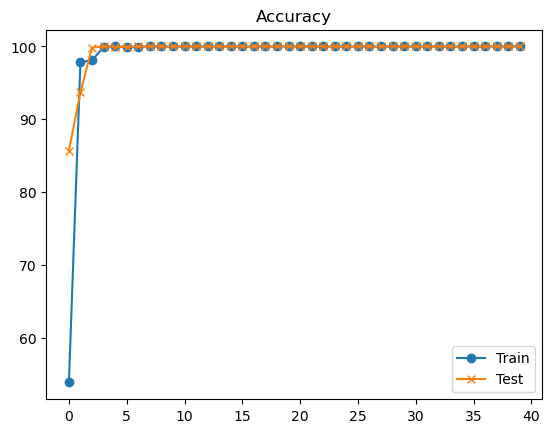

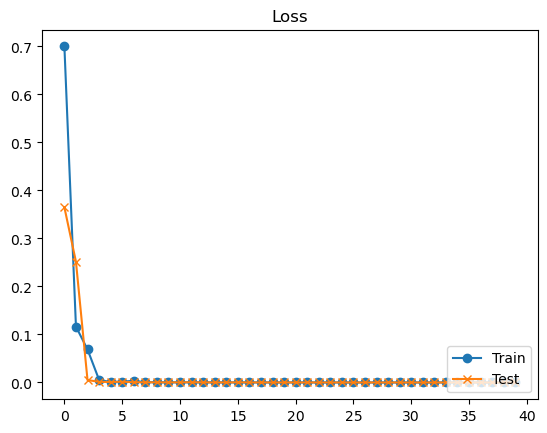

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.losses import BinaryCrossentropyLoss
from tqdm.auto import trange
import matplotlib.pyplot as plt


class FullyConnectedNet(Model):
    def __init__(self, hidden_dim, output_dim, activation='swish'):
        super(FullyConnectedNet, self).__init__()
        self.dense1 = Dense(hidden_dim, activation=activation)
        self.out = Dense(output_dim, activation=activation)
    def call(self,x):
        x = self.dense1(x)
        x = self.out(x)
        return x


def train(model, dataset, loss_obj, num_epochs, optimizer, train_loss, train_accuracy,
    test_dataset, test_loss, test_accuracy):
    
    arr_train_loss = np.zeros((num_epochs))
    arr_train_acc = np.zeros((num_epochs))
    arr_test_loss = np.zeros((num_epochs))
    arr_test_acc = np.zeros((num_epochs))
    for epoch in trange(num_epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        for X_data, labels in dataset.shuffle(10000).batch(50):
            with tf.GradientTape() as tape:
                pred = model(X_data, training=True)
                loss = loss_obj(labels, pred)
            
            grad = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

            train_loss(labels, pred)
            train_accuracy(labels, tf.squeeze(pred, axis=1))
        
        arr_train_acc[epoch] = train_accuracy.result() * 100
        arr_train_loss[epoch] = train_loss.result()

        for X_data, labels in test_dataset.shuffle(121345).batch(50):
            pred = model(X_data, training=False)
            loss = loss_obj(labels, pred)

            test_loss(labels, pred)
            test_accuracy(labels, tf.squeeze(pred, axis=1))
        arr_test_acc[epoch] = test_accuracy.result() * 100
        arr_test_loss[epoch] = test_loss.result()
        
        # if epoch%1 == 0:
        #     print(
        #         f'Epoch {epoch + 1}, '
        #         f'Loss: {train_loss.result()}, '
        #         f'Accuracy: {train_accuracy.result() * 100}'
        #     )
    plt.figure()
    plt.plot(np.arange(num_epochs),arr_train_acc, '-o', label="Train")
    plt.plot(np.arange(num_epochs), arr_test_acc, '-x', label="Test")
    plt.title("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.plot(np.arange(num_epochs),arr_train_loss, '-o', label="Train")
    plt.plot(np.arange(num_epochs), arr_test_loss, '-x', label="Test")
    plt.title("Loss")
    plt.legend(loc="lower right")
    plt.show()
# def test(model, dataset, loss_obj, num_epochs, optimizer, train_loss, train_accuracy):

def create_square_data():
    num_data = 200
    scale = 0.75
    shift = 0.2
    first_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    first_quad_labels = np.ones(num_data)

    second_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    second_quad_Xdata[:,0] = -second_quad_Xdata[:,0]  
    second_quad_labels = np.ones(num_data)

    third_quad_Xdata = -(scale*np.random.rand(num_data,2) + shift)
    third_quad_labels = np.zeros(num_data)

    fourth_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    fourth_quad_Xdata[:,1] = -fourth_quad_Xdata[:,1] 
    fourth_quad_labels = np.zeros(num_data)
    Xdata = np.concatenate((first_quad_Xdata, second_quad_Xdata,
        third_quad_Xdata, fourth_quad_Xdata), axis=0)
    labels = np.concatenate((first_quad_labels, second_quad_labels,
        third_quad_labels, fourth_quad_labels), axis=0)
    data_set = tf.data.Dataset.from_tensor_slices((Xdata, labels))
    plt.figure()
    plt.scatter(Xdata[:,0], Xdata[:,1])
    plt.show()
    return data_set


lr = ExponentialDecay(1.0, decay_steps=20, decay_rate=0.9, name="exponential_decay_schedule")
lr = 2
num_epochs = 40
dtype = tf.float64
model = FullyConnectedNet(2,1,'sigmoid')

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
train_loss = tf.keras.metrics.BinaryCrossentropy()
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
test_loss = tf.keras.metrics.BinaryCrossentropy()
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
training_data = np.loadtxt("training_data.txt")
test_data = np.loadtxt("test_data.txt")
training_data = tf.convert_to_tensor(training_data, dtype=dtype)
test_data = tf.convert_to_tensor(test_data, dtype=dtype)
X_train, y_train = training_data[:,1:], training_data[:,0]
X_test, y_test = training_data[:,1:], training_data[:,0]

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
)


test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)
)

# train(model, train_ds, loss_object, num_epochs, optimizer, train_loss, train_accuracy, 
#     test_ds, test_loss, test_accuracy)
train_ds = create_square_data()
test_ds = create_square_data()
train(model, train_ds, loss_object, num_epochs, optimizer, train_loss, train_accuracy, 
    test_ds, test_loss, test_accuracy)

a=1


(2000, 1)
(2000, 1)


<AxesSubplot: xlabel='x', ylabel='y'>

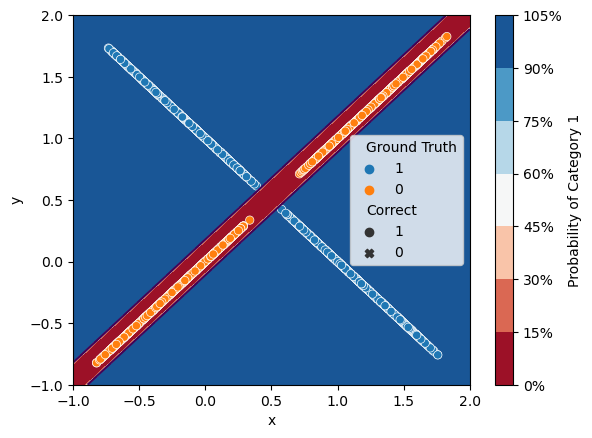

In [14]:
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
pred = tf.cast(model(X_test) > 0.5, tf.dtypes.uint8)
y_test = tf.cast(tf.reshape(y_test, (-1, 1)), tf.dtypes.uint8)
print(pred.shape)
print(y_test.shape)
df = pd.DataFrame(
    data={
        "x": X_test[:, 0],
        "y": X_test[:, 1],
        "Ground Truth": pd.Series(tf.reshape(y_test, (-1,))),
        "Prediction": pd.Series(tf.reshape(pred, (-1,))),
        "Correct": pd.Series(tf.reshape(y_test == pred, (-1,)), dtype=int),
    },
)
xlim = (-1, 2)
ylim = (-1, 2)
N_h_gridpoints = 100 * (xlim[1] - xlim[0])
N_v_gridpoints = 100 * (ylim[1] - ylim[0])

hmesh = np.linspace(*xlim, num=N_h_gridpoints)
vmesh = np.linspace(*ylim, num=N_v_gridpoints)

xgrid, ygrid = np.meshgrid(hmesh, vmesh)

onehotx, onehoty = xgrid.reshape((-1, 1)), ygrid.reshape((-1, 1))

onehotgrid = np.hstack((onehotx, onehoty))

onehotgridpred = model(onehotgrid)

gridpred = tf.reshape(onehotgridpred, xgrid.shape)

cf = plt.contourf(
    xgrid,
    ygrid,
    gridpred,
    cmap="RdBu",
)
plt.colorbar(
    cf,
    label="Probability of Category 1",
    spacing="proportional",
    format=PercentFormatter(xmax=1),
)

plt.contour(
    xgrid,
    ygrid,
    gridpred,
    levels=[0.5],
)
sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="Ground Truth",
    hue_order=[1, 0],
    style="Correct",
    style_order=[1, 0],
)
